In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import Bias
from janelia_core.ml.latent_regression.subject_models import LatentRegModel
from janelia_core.ml.latent_regression.group_maps import LinearMap
from janelia_core.ml.latent_regression.group_maps import IdentityMap
from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Parameters for model go here

In [3]:
d_in = [50, 70]
d_out = [20, 21]

d_proj = [2, 2]
d_trans = [2, 2]

n_smps = 10000

In [4]:
## Create the model here
n_output_groups = len(d_in)

#M = LinearMap(d_proj, d_trans)
M = IdentityMap()
S = [Bias(d_o) for d_o in d_out]
mdl = LatentRegModel(d_in, d_out, d_proj, d_trans, M, S, direct_pairs=None, w_gain=50, 
                    noise_range=[50.0, 100.0], apply_scales_and_offsets=False)

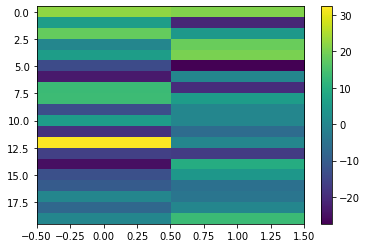

In [5]:
## Modify u[0] to make it sparse
u_orig = mdl.u[0].detach().numpy()
u_orig[np.abs(u_orig) < 4] = 0
plt.imshow(u_orig, aspect='auto', interpolation='none')
plt.colorbar()

## Generate some x data here

In [6]:
x = [torch.randn([n_smps, d]) for d in d_in]

## Run the model forward 

In [7]:
y_pred = mdl(x)
y = mdl.generate(x)

## Fit a new model

In [13]:
M_fitted = IdentityMap()
#M_fitted = LinearMap(d_proj, d_trans)
S_fitted = [Bias(d_o) for d_o in d_out]
fitted_mdl = LatentRegModel(d_in, d_out, d_proj, d_trans, M_fitted, S_fitted, direct_pairs=None, 
                            apply_scales_and_offsets=False)

## Move model to cuda

In [14]:
#fitted_mdl=fitted_mdl.cuda()
#x = [x_i.pin_memory() for x_i in x]
#y = [y_i.pin_memory() for y_i in y]

In [15]:
log = fitted_mdl.fit(x, y, max_its=10000, batch_size=10, send_size=10, update_int=1000, min_var = .01,
                     learning_rates=.01, l1_u_lambda = None)

/Users/bishopw/Documents/Janelia_Research/Projects/janelia_core/janelia_core/ml/latent_regression/subject_models.py:607: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629449223/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  small_psi_inds = torch.nonzero(psi_h < min_var)


0: Elapsed fitting time 7.200241088867188e-05, vl: 247815280.0, lr: 0.01
1000: Elapsed fitting time 1.2925260066986084, vl: 17160546.0, lr: 0.01
2000: Elapsed fitting time 2.610044002532959, vl: 2830878.2, lr: 0.01
3000: Elapsed fitting time 3.931387186050415, vl: 6739748.0, lr: 0.01
4000: Elapsed fitting time 5.219680070877075, vl: 3335260.8, lr: 0.01
5000: Elapsed fitting time 6.515795946121216, vl: 119766.4, lr: 0.01
6000: Elapsed fitting time 7.813791990280151, vl: 8366.525, lr: 0.01
7000: Elapsed fitting time 9.152005195617676, vl: 1029.892, lr: 0.01
8000: Elapsed fitting time 10.44501805305481, vl: 780.4803, lr: 0.01
9000: Elapsed fitting time 11.726179122924805, vl: 752.64105, lr: 0.01
9999: Elapsed fitting time 13.019475936889648, vl: 737.6461


In [16]:
%matplotlib qt
plt.figure()
plt.plot(log['elapsed_time'], log['obj'])

## Compare predictions from fitted model to ground truth

In [17]:
fitted_mdl = fitted_mdl.to('cpu')
x = [x_g.to('cpu') for x_g in x]
y = [y_h.to('cpu') for y_h in y]

plt_smps = np.arange(1000)

%matplotlib qt
true_y_hat = mdl(x)
fitted_y_hat = fitted_mdl(x)

for g in range(n_output_groups):
    plt.figure()
    for d in range(5):
        plt.subplot(1, 5, d+1)
        true_obs_values = y[g][plt_smps, d].detach().numpy()
        true_plt_values = true_y_hat[g][plt_smps, d].detach().numpy()
        fitted_plt_values = fitted_y_hat[g][plt_smps, d].detach().numpy()
        plt.plot(true_obs_values, 'go')
        plt.plot(true_plt_values, 'ro')
        plt.plot(fitted_plt_values, 'b-')